# Modeling

In [82]:
# Import libraries
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import datetime
from sklearn.metrics import precision_recall_curve, average_precision_score

In [2]:
# Load transformed files

file_names = ['X_train_unscaled', 'X_test_unscaled', 'X_train_scaled', 'X_test_scaled', \
              'y_train', 'y_test' ,'X_val_unscaled' , 'X_val_scaled', 'y_val']

# Base directory path
directory = r'C:\Users\Travi\OneDrive\Documents\GitHub\Springboard-Data-Science-Capstone-Project-2\Cleaned_data'

dataframes = {}

# Loop through each dataset name
for file in file_names:
    # Construct the full path dynamically
    file_path = f"{directory}\\{file}.csv"
    file_name = os.path.basename(file)
    
    # Read the CSV into a DataFrame and store it in the dictionary
    dataframes[file] = pd.read_csv(file_path)
    print(f"{file_name} loaded successfully")
    
# Extract DataFrames from the dictionary and assign them to individual variables
for dataset_name, df in dataframes.items():
            globals()[dataset_name] = df  # Create a variable with the name of the dataset

X_train_unscaled loaded successfully
X_test_unscaled loaded successfully
X_train_scaled loaded successfully
X_test_scaled loaded successfully
y_train loaded successfully
y_test loaded successfully
X_val_unscaled loaded successfully
X_val_scaled loaded successfully
y_val loaded successfully


### Class Distribution

In [3]:
# Class distribution
goal_counts = y_train.value_counts()
print("Class Distribution in Training Set:")
print(goal_counts)

# Calculate imbalance ratio
imbalance_ratio = goal_counts[0] / goal_counts[1]  # Non-goals / Goals
print(f"Imbalance Ratio (Non-goals:Goals) = {imbalance_ratio:.2f}")

Class Distribution in Training Set:
goal
0       1102390
1        111878
Name: count, dtype: int64
Imbalance Ratio (Non-goals:Goals) = 9.85


### Resample and Undersampling to Balance Class Distribution

#### SMOTE 

In [101]:
X_scaled_resampled, y_scaled_resampled = SMOTE(sampling_strategy=0.5, random_state=42).fit_resample(X_train_scaled, y_train)

In [100]:
X_unscaled_resampled, y_unscaled_resampled = SMOTE(sampling_strategy=0.5, random_state=42).fit_resample(X_train_unscaled, y_train)

#### Unersampling

In [94]:
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# Apply undersampling to training data
X_train_scaled_undersampled, y_train_scaled_undersampled = undersample.fit_resample(X_train_scaled, y_train)

In [95]:
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# Apply undersampling to training data
X_train_unscaled_undersampled, y_train_unscaled_undersampled = undersample.fit_resample(X_train_unscaled, y_train)

### Logistic Regression Model

First I trained all the models on the original data as a baseline. I then training the models using the resampled data (both oversampling and undersampling) to help with the class imbalance.  

To evaluate my model, I will be focused on maximizing recall. I want to catch all legitimate goal-scoring chances, even at the risk of some false alarms.

The goal is to use the model to uncover hidden offensive potential — e.g., finding players who create high-quality chances that others don’t finish often.

In [8]:
# Train the model
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train_scaled, y_train.values.ravel())

# Predict and evaluate
y_pred_log = log_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred_log))

# ROC-AUC Score
y_pred_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_log = roc_auc_score(y_test, y_pred_proba_log)
print(f"ROC-AUC: {roc_auc_log}")

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     11249
           1       0.24      0.74      0.36      1142

    accuracy                           0.76     12391
   macro avg       0.60      0.75      0.61     12391
weighted avg       0.90      0.76      0.81     12391

ROC-AUC: 0.8375925690378548


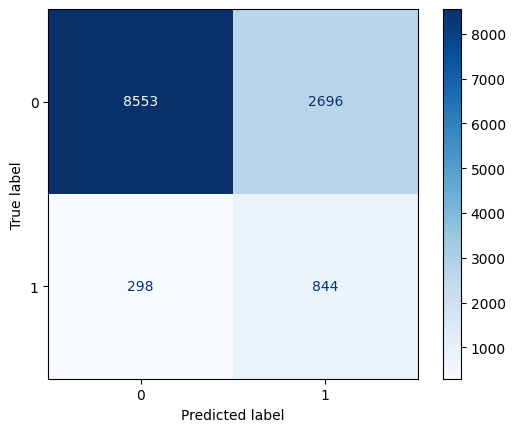

In [146]:
cm_log_model = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_model)
disp.plot(cmap=plt.cm.Blues)

In [140]:
# Train the model
log_model2 = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model2.fit(X_scaled_resampled, y_scaled_resampled.values.ravel())

# Predict and evaluate
y_pred_log2 = log_model2.predict(X_test_scaled)

print(classification_report(y_test, y_pred_log2))

# ROC-AUC Score
y_pred_proba_log2 = log_model2.predict_proba(X_test_scaled)[:, 1]
roc_auc_log2 = roc_auc_score(y_test, y_pred_proba_log2)
print(f"ROC-AUC: {roc_auc_log}")

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     11249
           1       0.24      0.74      0.36      1142

    accuracy                           0.76     12391
   macro avg       0.60      0.75      0.61     12391
weighted avg       0.90      0.76      0.81     12391

ROC-AUC: 0.8375925690378548


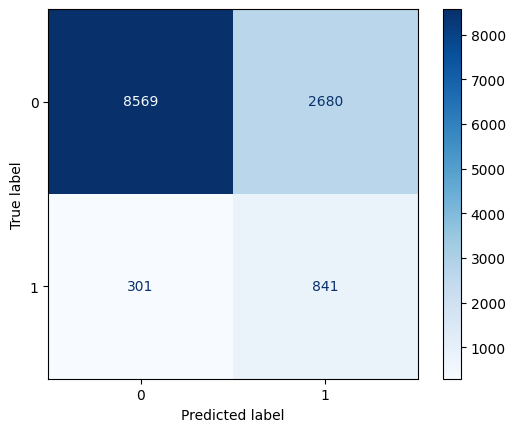

In [147]:
cm_log_model2 = confusion_matrix(y_test, y_pred_log2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_model2)
disp.plot(cmap=plt.cm.Blues)

In [142]:
# Train the model
log_model3 = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model3.fit(X_train_scaled_undersampled, y_train_scaled_undersampled.values.ravel())

# Predict and evaluate
y_pred_log3 = log_model3.predict(X_test_scaled)

print(classification_report(y_test, y_pred_log3))

# ROC-AUC Score
y_pred_proba_log3 = log_model3.predict_proba(X_test_scaled)[:, 1]
roc_auc_log3 = roc_auc_score(y_test, y_pred_proba_log3)
print(f"ROC-AUC: {roc_auc_log}")

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     11249
           1       0.24      0.74      0.36      1142

    accuracy                           0.76     12391
   macro avg       0.60      0.75      0.61     12391
weighted avg       0.90      0.76      0.81     12391

ROC-AUC: 0.8375925690378548


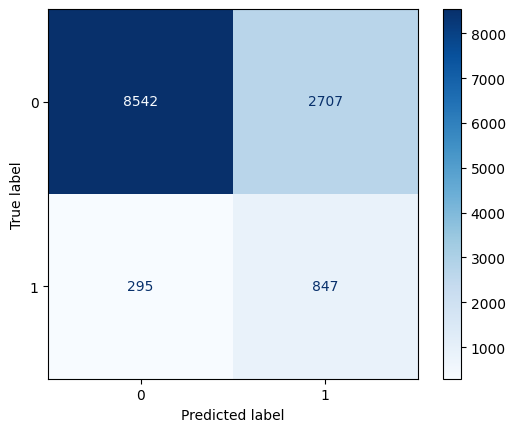

In [148]:
cm_log_model3 = confusion_matrix(y_test, y_pred_log3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_model3)
disp.plot(cmap=plt.cm.Blues)

### Hyperparamater Tuning for Logistic Regression Model

In [14]:
# Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Lasso or Ridge
    'solver': ['liblinear', 'saga']  # Required for L1 regularization
}

# Initialize model
log_reg = LogisticRegression(max_iter=500, class_weight='balanced')

# Perform GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train.values.ravel())

# Best Parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best Model
best_log_reg = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\Travi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [177]:
# Train the model
log_model4 = LogisticRegression(max_iter=1000, class_weight='balanced', C=10, penalty='l1', solver='liblinear')
log_model4.fit(X_train_scaled, y_train.values.ravel())

# Predict and evaluate
y_pred_log4 = log_model4.predict(X_test_scaled)

print(classification_report(y_test, y_pred_log4))

# ROC-AUC Score
y_pred_proba_log4 = log_model4.predict_proba(X_test_scaled)[:, 1]
roc_auc_log4 = roc_auc_score(y_test, y_pred_proba_log4)
print(f"ROC-AUC: {roc_auc_log}")

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     11249
           1       0.24      0.74      0.36      1142

    accuracy                           0.76     12391
   macro avg       0.60      0.75      0.61     12391
weighted avg       0.90      0.76      0.81     12391

ROC-AUC: 0.8375925690378548


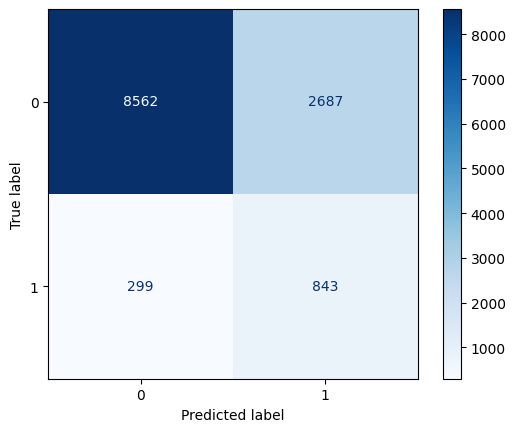

In [178]:
cm_log_model4 = confusion_matrix(y_test, y_pred_log4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_model4)
disp.plot(cmap=plt.cm.Blues)

### Random Forest Model

Next, I explored Random Forest Model due to its ablity to handle non-linear relationships and outliers better than logistic regression. I repeated the same process with Random Forest as I did with Logistic Regression

In [166]:
# Train the model
forest_model = RandomForestClassifier(n_estimators = 100,class_weight='balanced',random_state=42)
forest_model.fit(X_train_unscaled, y_train.values.ravel())

# Predict
y_pred_forest = forest_model.predict(X_test_unscaled)
y_pred_proba_forest = forest_model.predict_proba(X_test_unscaled)[:, 1] 

# Evaluate
print(classification_report(y_test, y_pred_forest))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_forest))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11249
           1       0.89      0.18      0.31      1142

    accuracy                           0.92     12391
   macro avg       0.90      0.59      0.63     12391
weighted avg       0.92      0.92      0.90     12391

ROC-AUC: 0.8397427115140338


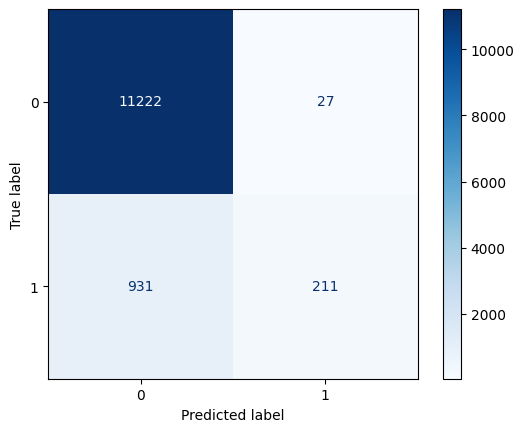

In [167]:
cm_forest_model = confusion_matrix(y_test, y_pred_forest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_forest_model)
disp.plot(cmap=plt.cm.Blues)

In [179]:
forest_model2 = RandomForestClassifier(n_estimators = 100,random_state=42)
forest_model2.fit(X_unscaled_resampled, y_unscaled_resampled.values.ravel())

y_pred_forest2 = log_model2.predict(X_test_unscaled)
y_pred_proba_forest2 = forest_model2.predict_proba(X_test_unscaled)[:, 1] 

# Evaluate
print(classification_report(y_test, y_pred_forest2))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_forest2))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11249
           1       0.00      0.00      0.00      1142

    accuracy                           0.91     12391
   macro avg       0.45      0.50      0.48     12391
weighted avg       0.82      0.91      0.86     12391

ROC-AUC: 0.8323532241589406


C:\Users\Travi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Travi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Travi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

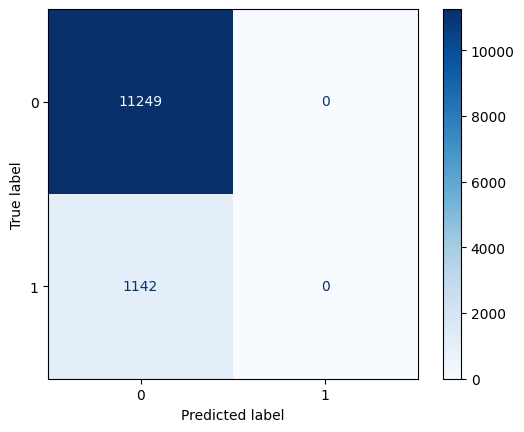

In [180]:
cm_forest_model2 = confusion_matrix(y_test, y_pred_forest2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_forest_model2)
disp.plot(cmap=plt.cm.Blues)

In [170]:
forest_model3 = RandomForestClassifier(n_estimators = 100,random_state=42)
forest_model3.fit(X_train_unscaled_undersampled, y_train_unscaled_undersampled.values.ravel())

y_pred_forest3 = log_model3.predict(X_test_scaled)
y_pred_proba_forest3 = forest_model3.predict_proba(X_test_unscaled)[:, 1] 

# Evaluate
print(classification_report(y_test, y_pred_forest3))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_forest3))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     11249
           1       0.24      0.74      0.36      1142

    accuracy                           0.76     12391
   macro avg       0.60      0.75      0.61     12391
weighted avg       0.90      0.76      0.81     12391

ROC-AUC: 0.8427964563964354


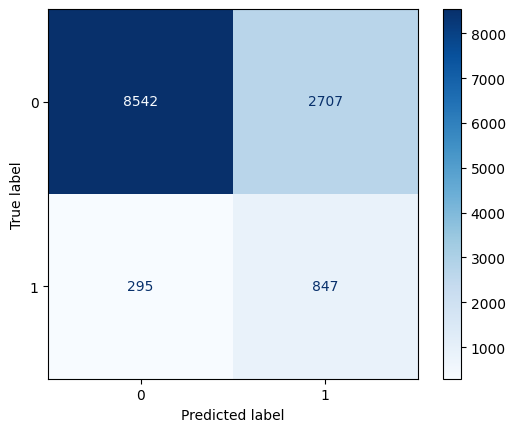

In [171]:
cm_forest_model3 = confusion_matrix(y_test, y_pred_forest3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_forest_model3)
disp.plot(cmap=plt.cm.Blues)

### Random Forest Hyperparameter Tuning

Did not have enough system resources to run the hyperparameter tuning below and was run in Google colab to generate parameters used for forest_model4

In [ ]:
# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 500],  # Number of trees
    'max_depth': [5, 10, 20, None],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples in a leaf
    'max_features': ['sqrt', 'log2', None]  # Feature selection
}

# Initialize model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
                                   n_iter=20, scoring='f1', cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_resampled_unscaled, y_train_resampled_unscaled)

# Best Parameters
print("Best Hyperparameters:", random_search.best_params_)

# Best Model
best_rf_model = random_search.best_estimator_

In [173]:
# Train the model
forest_model4 = RandomForestClassifier(n_estimators=100, min_samples_split=10, class_weight='balanced', min_samples_leaf=4, max_features='sqrt', max_depth=20, random_state=42)
forest_model4.fit(X_train_unscaled_undersampled, y_train_unscaled_undersampled.values.ravel())

# Predict
y_pred_forest4 = forest_model4.predict(X_test_unscaled)
y_pred_proba_forest4 = forest_model4.predict_proba(X_test_unscaled)[:, 1]  # For ROC-AUC

# Evaluate
print(classification_report(y_test, y_pred_forest4))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_forest4))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86     11249
           1       0.25      0.75      0.37      1142

    accuracy                           0.77     12391
   macro avg       0.61      0.76      0.61     12391
weighted avg       0.90      0.77      0.81     12391

ROC-AUC: 0.8484262232143928


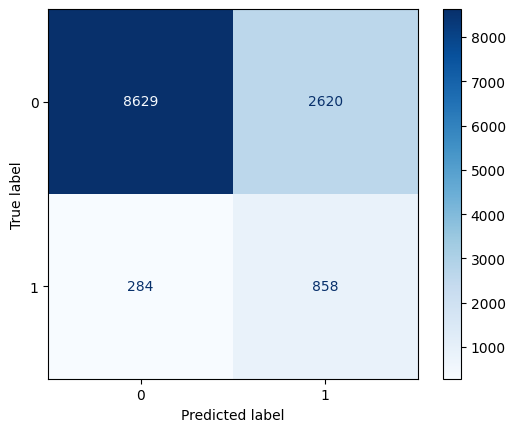

In [174]:
cm_forest_model4 = confusion_matrix(y_test, y_pred_forest4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_forest_model4)
disp.plot(cmap=plt.cm.Blues)

### XGBoost Model

The last model that I tested was XGBoost. I choose this model because of its predictive performance, especially on large and complex datasets, and its ability to handle imbalanced data better than Random Forest. 

In [158]:
from xgboost import XGBClassifier

# # Train the model
xgb_model = XGBClassifier (eval_metric='logloss', scale_pos_weight=9.85)
xgb_model.fit(X_train_unscaled, y_train)

# Evaluate
y_pred_xgb = xgb_model.predict(X_test_unscaled)
print(classification_report(y_test, y_pred_xgb))

y_pred_proba_xgb = xgb_model.predict_proba(X_test_unscaled)[:, 1]  # For ROC-AUC
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb))

              precision    recall  f1-score   support

           0       0.97      0.73      0.83     11249
           1       0.23      0.81      0.36      1142

    accuracy                           0.74     12391
   macro avg       0.60      0.77      0.60     12391
weighted avg       0.91      0.74      0.79     12391

ROC-AUC: 0.8530957567895897


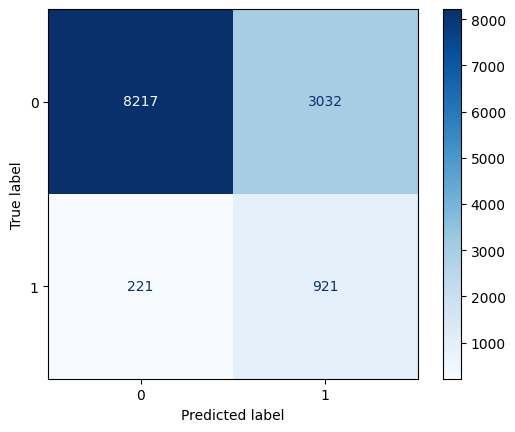

In [159]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot(cmap=plt.cm.Blues)

In [66]:
xgb_model2 = XGBClassifier (eval_metric='logloss', scale_pos_weight=5)
xgb_model2.fit(X_train_unscaled, y_train)

# Evaluate
y_pred_xgb2 = xgb_model2.predict(X_test_unscaled)
print(classification_report(y_test, y_pred_xgb2))

y_pred_proba_xgb2 = xgb_model2.predict_proba(X_test_unscaled)[:, 1]  # For ROC-AUC
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb2))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     11249
           1       0.33      0.58      0.42      1142

    accuracy                           0.85     12391
   macro avg       0.64      0.73      0.67     12391
weighted avg       0.90      0.85      0.87     12391

ROC-AUC: 0.8538474873578957


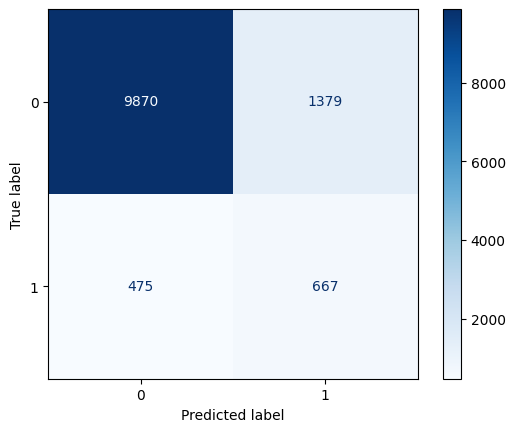

In [160]:
cm_xgb2 = confusion_matrix(y_test, y_pred_xgb2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb2)
disp.plot(cmap=plt.cm.Blues)

In [68]:
xgb_model3 = XGBClassifier (eval_metric='logloss', scale_pos_weight=5)
xgb_model3.fit(X_unscaled_resampled, y_resampled)

# Evaluate
y_pred_xgb3 = xgb_model3.predict(X_test_unscaled)
print(classification_report(y_test, y_pred_xgb3))

y_pred_proba_xgb3 = xgb_model3.predict_proba(X_test_unscaled)[:, 1]  # For ROC-AUC
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb3))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     11249
           1       0.31      0.59      0.41      1142

    accuracy                           0.84     12391
   macro avg       0.63      0.73      0.66     12391
weighted avg       0.90      0.84      0.86     12391

ROC-AUC: 0.8517068806583158


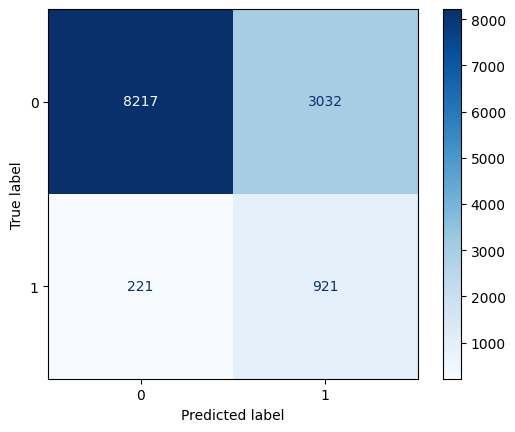

In [161]:
cm_xgb3 = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb3)
disp.plot(cmap=plt.cm.Blues)

### XGBoost Hyperparameter Tuning

In [84]:
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 10],
    'min_child_weight': [1, 3, 5, 7, 10],
    'gamma': [0, 0.1, 0.5, 1],
    'lambda': [0, 1, 5, 10],
    'alpha' : [0, 0.1, 1, 5, 10],
    'scale_pos_weight': [1,5,7,imbalance_ratio]  # Handles class imbalance
}

# Initialize XGBoost Model
xgb2 = XGBClassifier(random_state=42, eval_metric="logloss")

# Perform RandomizedSearchCV
xgb_cv2 = RandomizedSearchCV(xgb2, param_distributions=param_grid, 
                            n_iter=20, scoring='f1', cv=5, verbose=1, random_state=42, n_jobs=-1)
xgb_cv2.fit(X_train_unscaled, y_train)

# Print Best Parameters
print("Best Hyperparameters:", xgb_cv2.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Travi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Travi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Travi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Travi\AppData\Local\Programs\Python\Python312\Lib\site-package

Best Hyperparameters: {'scale_pos_weight': 5, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 10, 'gamma': 0, 'alpha': 10}


I then tested the same models using the tuned hyperparameters

In [184]:
xgb_model4 = XGBClassifier (eval_metric='logloss', scale_pos_weight=9.85, n_estimators=1000, min_child_weight=5, max_depth=5, learning_rate=0.1,
                            gamma=0, alpha=10, reg_lambda=10)
xgb_model4.fit(X_train_unscaled, y_train)

# Evaluate
y_pred_xgb4 = xgb_model4.predict(X_test_unscaled)
print(classification_report(y_test, y_pred_xgb4))

y_pred_proba_xgb4 = xgb_model4.predict_proba(X_test_unscaled)[:, 1]  # For ROC-AUC
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb4))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     11249
           1       0.23      0.80      0.36      1142

    accuracy                           0.74     12391
   macro avg       0.60      0.77      0.60     12391
weighted avg       0.90      0.74      0.79     12391

ROC-AUC: 0.8553127275450366


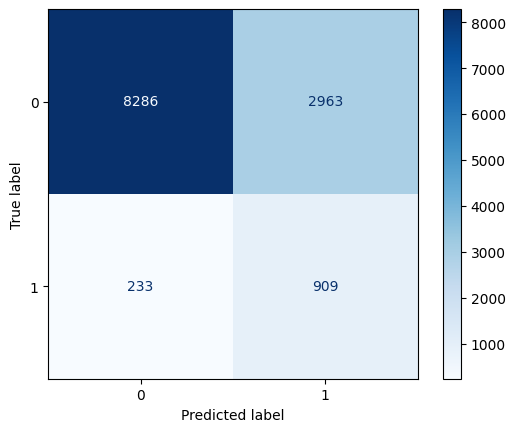

In [185]:
cm_xgb4 = confusion_matrix(y_test, y_pred_xgb4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb4)
disp.plot(cmap=plt.cm.Blues)

In [134]:
xgb_model5 = XGBClassifier (eval_metric='logloss', scale_pos_weight=9.85, n_estimators=1000, min_child_weight=5, max_depth=5, learning_rate=0.1,
                            gamma=0, alpha=10, reg_lambda=10)
xgb_model5.fit(X_unscaled_resampled, y_unscaled_resampled)

# Evaluate
y_pred_xgb5 = xgb_model5.predict(X_test_unscaled)
print(classification_report(y_test, y_pred_xgb5))

y_pred_proba_xgb5 = xgb_model5.predict_proba(X_test_unscaled)[:, 1]  # For ROC-AUC
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb5))

              precision    recall  f1-score   support

           0       0.97      0.73      0.83     11249
           1       0.23      0.80      0.36      1142

    accuracy                           0.74     12391
   macro avg       0.60      0.77      0.60     12391
weighted avg       0.91      0.74      0.79     12391

ROC-AUC: 0.8542820463200543


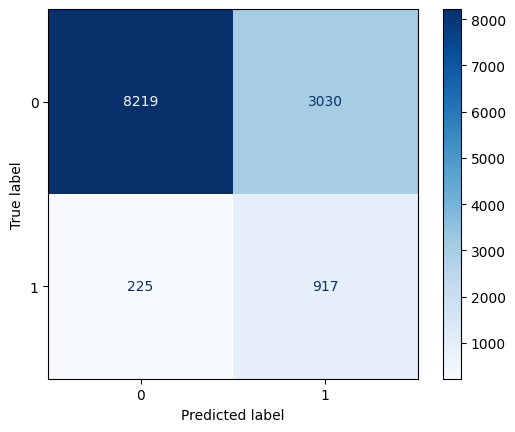

In [163]:
cm_xgb5 = confusion_matrix(y_test, y_pred_xgb5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb5)
disp.plot(cmap=plt.cm.Blues)

In [136]:
xgb_model6 = XGBClassifier (eval_metric='logloss', scale_pos_weight=9.85, n_estimators=1000, min_child_weight=5, max_depth=5, learning_rate=0.1,
                            gamma=0, alpha=10)
xgb_model6.fit(X_train_unscaled_undersampled, y_train_unscaled_undersampled)

# Evaluate
y_pred_xgb6 = xgb_model6.predict(X_test_unscaled)
print(classification_report(y_test, y_pred_xgb6))

y_pred_proba_xgb6 = xgb_model6.predict_proba(X_test_unscaled)[:, 1]  # For ROC-AUC
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb6))

              precision    recall  f1-score   support

           0       0.99      0.39      0.56     11249
           1       0.14      0.97      0.24      1142

    accuracy                           0.44     12391
   macro avg       0.57      0.68      0.40     12391
weighted avg       0.91      0.44      0.53     12391

ROC-AUC: 0.8525947587635343


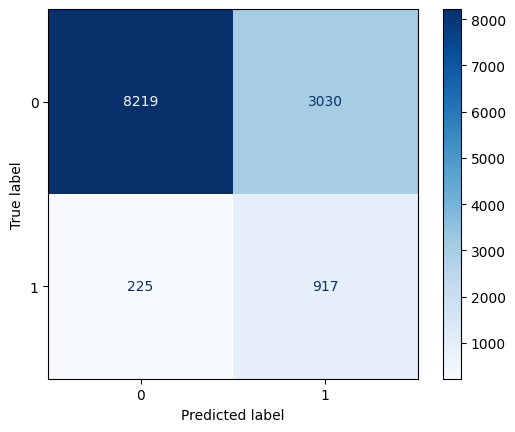

In [164]:
cm_xgb6 = confusion_matrix(y_test, y_pred_xgb5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb6)
disp.plot(cmap=plt.cm.Blues)

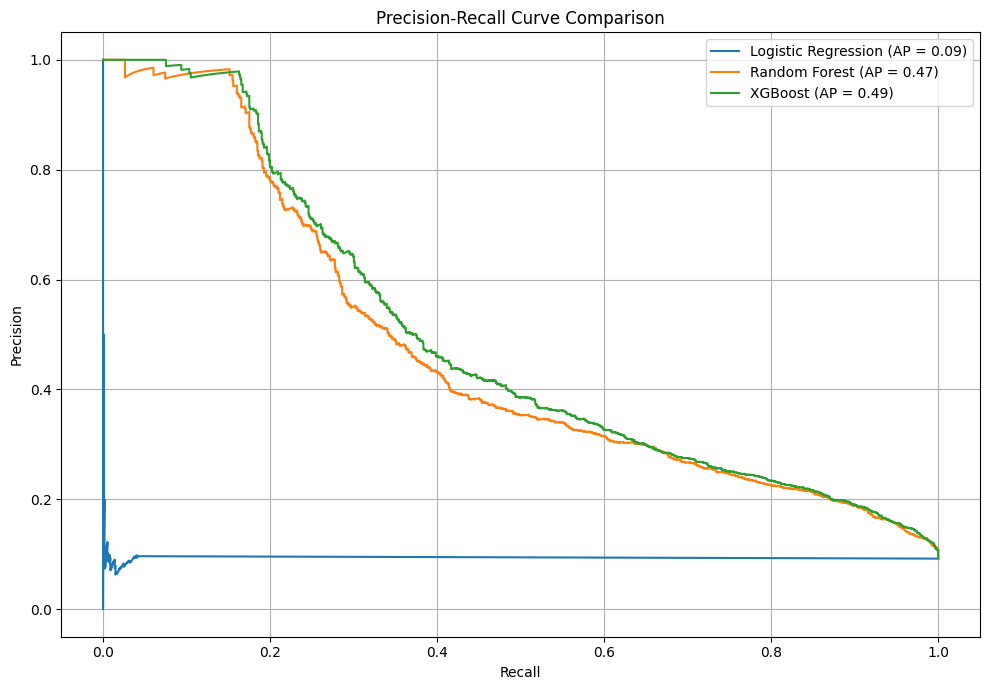

In [186]:

# Store models in a dictionary for easy iteration
models = {
    "Logistic Regression": log_model,
    "Random Forest": forest_model4,
    "XGBoost": xgb_model4
}

plt.figure(figsize=(10, 7))

# Loop through each model and compute precision-recall
for name, model in models.items():
    # Get predicted probabilities for the positive class
    if name == "XGBoost":
        y_scores = model.predict_proba(X_test_unscaled)[:, 1]  # For XGBClassifier
    elif name == "Random Forest":
        y_scores = model.predict_proba(X_test_unscaled)[:, 1]
    else:
        y_scores = model.predict_proba(X_test_unscaled)[:, 1]  # For scikit-learn models

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)

    plt.plot(recall, precision, label=f"{name} (AP = {avg_precision:.2f})")

# Plot styling
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

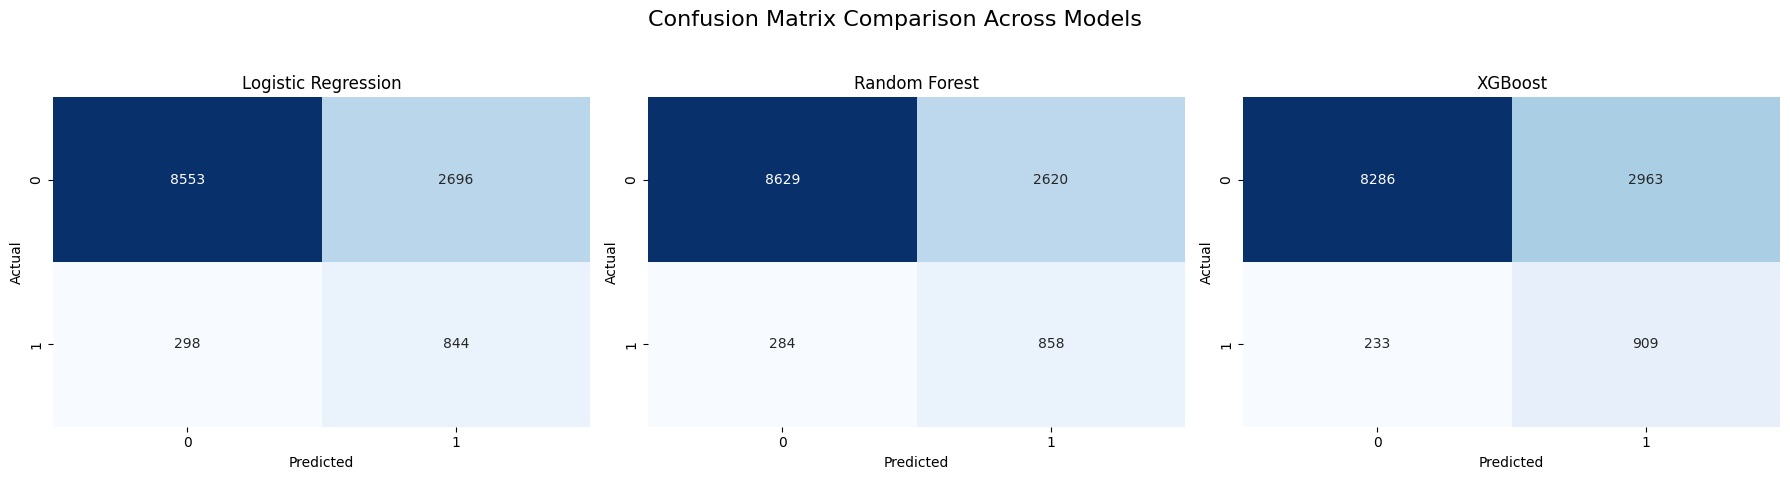

In [187]:
model_preds = {
    "Logistic Regression": y_pred_log ,
    "Random Forest": y_pred_forest4,
    "XGBoost": y_pred_xgb4
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (model_name, y_pred) in zip(axes, model_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('Confusion Matrix Comparison Across Models', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Aggretate Predictions by Player

Now that I have my trained models, I need to aggregate the goal predictions by player since out goal is to predict a players goals for the next season.  First, I started by loading the shot data from 2023 which was not included in the training data. Training data only went to 2022. 

In [47]:
test1 = pd.read_csv(r"C:\Users\Travi\OneDrive\Documents\GitHub\Springboard-Data-Science-Capstone-Project-2\Raw_data\shots_2023.csv")

In [48]:
cols_to_keep = ['shotID', 'homeTeamCode', 'awayTeamCode', 'season', 'game_id','id',
            'timeSinceLastEvent', 'period', 'team', 'location', 'shotGeneratedRebound','shotAngle', 'shotAnglePlusRebound',
            'shotDistance', 'shotType', 'shotOnEmptyNet', 'shotRebound', 'shotAnglePlusReboundSpeed', 
            'shotRush', 'speedFromLastEvent', 'distanceFromLastEvent',
            'lastEventShotAngle', 'lastEventShotDistance', 'lastEventCategory', 'homeEmptyNet',
            'awayEmptyNet', 'homeSkatersOnIce', 'awaySkatersOnIce', 'playerPositionThatDidEvent', 
            'timeSinceFaceoff', 'shooterPlayerId', 'shooterLeftRight', 'xGoal', 'xFroze',
            'xRebound', 'xPlayContinuedInZone', 'xPlayContinuedOutsideZone', 'xPlayStopped',
            'xShotWasOnGoal', 'shotWasOnGoal', 'teamCode', 'power_play', 'situation', 'homePenalty1Length', 'awayPenalty1Length', 'goal']

test1 = test1[test1.columns.intersection(cols_to_keep)]
test1.reset_index()

,index,shotID,awayEmptyNet,awayPenalty1Length,awaySkatersOnIce,awayTeamCode,distanceFromLastEvent,game_id,goal,homeEmptyNet,...,teamCode,timeSinceFaceoff,timeSinceLastEvent,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal
0,0,0,0,0,5,NSH,56.035703,20001,0,0,...,TBL,26,3,0.249174,0.035813,0.379310,0.277143,0.022744,0.035816,0.751320
1,1,1,0,0,5,NSH,40.496913,20001,0,0,...,TBL,35,9,0.107945,0.057705,0.464358,0.298119,0.020588,0.051284,0.589712
2,2,2,0,0,5,NSH,120.432554,20001,0,0,...,TBL,72,11,0.236193,0.016126,0.390417,0.301375,0.025621,0.030269,0.785765
3,3,3,0,0,5,NSH,21.213203,20001,0,0,...,TBL,68,32,0.198635,0.016797,0.438052,0.291724,0.021107,0.033686,0.724471
4,4,4,0,0,5,NSH,129.799846,20001,0,0,...,NSH,122,19,0.188582,0.008709,0.406288,0.349752,0.019523,0.027146,0.727481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122467,122467,76,0,0,5,EDM,17.262677,30417,0,0,...,EDM,39,30,0.138671,0.167789,0.325661,0.279878,0.022867,0.065133,0.796396
122468,122468,77,0,0,5,EDM,21.470911,30417,0,0,...,EDM,64,11,0.130346,0.022553,0.437249,0.323969,0.023288,0.062595,0.716815
122469,122469,78,0,0,5,EDM,31.064449,30417,0,0,...,EDM,64,0,0.202369,0.502383,0.092294,0.031397,0.068653,0.102904,0.961081
122470,122470,79,0,0,5,EDM,11.661904,30417,0,0,...,EDM,67,3,0.147753,0.103143,0.393179,0.245710,0.036371,0.073843,0.733001


Once loaded I added matching power play and situation columns in order to match the training data. 

In [49]:
#Add a new column to the dataframe to easily identify Power Play goals

test1['power_play'] = test1.apply\
                                    (lambda row: "1" if row['homePenalty1Length'] or row['awayPenalty1Length'] > 0 else "0", axis=1)
test1['power_play'] = test1['power_play'].astype(int)

In [50]:
#Add a new column to the dataframe to identify how many skaters from each team were on the ice at the time of the goal.

def determine_situation(row):
    if row.loc['team'] == 'HOME' and row.loc['homeSkatersOnIce'] == 5 and row.loc['awaySkatersOnIce'] == 6:
        return '5v6'
    elif row.loc['team'] == 'HOME' and row.loc['homeSkatersOnIce'] == 6 and row.loc['awaySkatersOnIce'] == 5:
        return '6v5'
    elif row.loc['team'] == 'HOME' and row.loc['homeSkatersOnIce'] == 5 and row.loc['awaySkatersOnIce'] == 4:
        return '5v4'
    elif row.loc['team'] == 'HOME' and row.loc['homeSkatersOnIce'] == 5 and row.loc['awaySkatersOnIce'] == 3:
        return '5v3'
    elif row.loc['team'] == 'HOME' and row.loc['homeSkatersOnIce'] == 4 and row.loc['awaySkatersOnIce'] == 5:
        return '4v5'
    elif row.loc['team'] == 'HOME' and row.loc['homeSkatersOnIce'] == 3 and row.loc['awaySkatersOnIce'] == 5:
        return '3v5'
    elif row.loc['team'] == 'AWAY' and row.loc['homeSkatersOnIce'] == 5 and row.loc['awaySkatersOnIce'] == 6:
        return '6v5'
    elif row.loc['team'] == 'AWAY' and row.loc['homeSkatersOnIce'] == 6 and row.loc['awaySkatersOnIce'] == 5:
        return '5v6'
    elif row.loc['team'] == 'AWAY' and row.loc['homeSkatersOnIce'] == 4 and row.loc['awaySkatersOnIce'] == 5:
        return '5v4'
    elif row.loc['team'] == 'AWAY' and row.loc['homeSkatersOnIce'] == 3 and row.loc['awaySkatersOnIce'] == 5:
        return '5v3'
    elif row.loc['team'] == 'AWAY' and row.loc['homeSkatersOnIce'] == 5 and row.loc['awaySkatersOnIce'] == 4:
        return '4v5'
    elif row.loc['team'] == 'AWAY' and row.loc['homeSkatersOnIce'] == 5 and row.loc['awaySkatersOnIce'] == 3:
        return '3v5'
    else:
        return '5v5'

# Adding the new column

test1['situation'] = test1.apply(determine_situation, axis=1)
test1.head()

,shotID,awayEmptyNet,awayPenalty1Length,awaySkatersOnIce,awayTeamCode,distanceFromLastEvent,game_id,goal,homeEmptyNet,homePenalty1Length,...,timeSinceLastEvent,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,power_play,situation
0,0,0,0,5,NSH,56.035703,20001,0,0,0,...,3,0.249174,0.035813,0.379310,0.277143,0.022744,0.035816,0.751320,0,5v5
1,1,0,0,5,NSH,40.496913,20001,0,0,0,...,9,0.107945,0.057705,0.464358,0.298119,0.020588,0.051284,0.589712,0,5v5
2,2,0,0,5,NSH,120.432554,20001,0,0,0,...,11,0.236193,0.016126,0.390417,0.301375,0.025621,0.030269,0.785765,0,5v5
3,3,0,0,5,NSH,21.213203,20001,0,0,0,...,32,0.198635,0.016797,0.438052,0.291724,0.021107,0.033686,0.724471,0,5v5
4,4,0,0,5,NSH,129.799846,20001,0,0,0,...,19,0.188582,0.008709,0.406288,0.349752,0.019523,0.027146,0.727481,0,5v5


In [76]:
features = cols_to_keep = ['shotID', 'homeTeamCode', 'awayTeamCode', 'season', 'game_id','id',
            'timeSinceLastEvent', 'period', 'team', 'location', 'shotGeneratedRebound','shotAngle', 'shotAnglePlusRebound',
            'shotDistance', 'shotType', 'shotOnEmptyNet', 'shotRebound', 'shotAnglePlusReboundSpeed', 
            'shotRush', 'speedFromLastEvent', 'distanceFromLastEvent',
            'lastEventShotAngle', 'lastEventShotDistance', 'lastEventCategory', 'homeEmptyNet',
            'awayEmptyNet', 'homeSkatersOnIce', 'awaySkatersOnIce', 'playerPositionThatDidEvent', 
            'timeSinceFaceoff', 'shooterPlayerId', 'shooterLeftRight', 'xGoal', 'xFroze',
            'xRebound', 'xPlayContinuedInZone', 'xPlayContinuedOutsideZone', 'xPlayStopped',
            'xShotWasOnGoal', 'shotWasOnGoal', 'teamCode', 'power_play', 'situation']

In [51]:
# Drop unwanted columns
test1 = test1.drop(columns=['homePenalty1Length', 'awayPenalty1Length'])

In [52]:
from IPython.display import display
pd.options.display.float_format = '{:.18f}'.format

In [53]:
# Scale player id column to match training and testing data
test1['shooterPlayerId'] = np.log1p(abs(test1['shooterPlayerId']))
test1['shooterPlayerId']

0        15.953006244141992198
1        15.952986428369698046
2        15.953181148483148277
3        15.953172893403060328
4        15.952853959281956264
                  ...         
122467   15.953032664560918619
122468   15.953032664560918619
122469   15.952657051604887783
122470   15.952657051604887783
122471   15.953049176968283618
Name: shooterPlayerId, Length: 122472, dtype: float64

In [54]:
# Funcion to predict goals for a speific player based on their shot data

def predict_goals_for_player(player_id, model, player_shot_data, feature_columns):
    """
    Predict the number of goals for a specific player based on their shot data.

    Parameters:
    - player_id: str or int, the ID of the player
    - model: trained classification model
    - player_shot_data: DataFrame containing all shot-level data (with player_id)
    - feature_columns: list of columns used for modeling (same as X_train.columns)

    Returns:
    - predicted_goals: float, expected number of goals
    - num_shots: int, total shots for this player
    """
    # Filter shot-level data for this player
    player_data = player_shot_data[player_shot_data['shooterPlayerId'] == player_id]
    
    if player_data.empty:
        print(f"No shot data found for player ID: {player_id}")
        return 0, 0

    # Extract only feature columns 
    X_player = player_data[feature_columns].copy()
    
    # Make predictions
    goal_probs = model.predict_proba(X_player)[:, 1]
    
    # Total predicted goals = sum of probabilities
    predicted_goals = goal_probs.sum()
    
    return predicted_goals, len(goal_probs)

In [130]:
# Make goal predictions based on player id

player_id = 15.953181148483148277
predicted_goals, num_shots = predict_goals_for_player(player_id, xgb_model4, X_test_unscaled, X_val_unscaled.columns)

print(f"Player {player_id} is expected to score {predicted_goals:.1f} goals based on {num_shots} shots.")

Player 15.953181148483148 is expected to score 0.4 goals based on 2 shots.


In [131]:
#Compare prediction to actual totals from next season

player_shot_data = test1[test1['shooterPlayerId'] == player_id]
acutal_goals = player_shot_data['goal'].sum()
print(f"Predicted goals {predicted_goals:.1f} vs Actual goals {acutal_goals}")

Predicted goals 0.4 vs Actual goals 7
